In [1]:
shape_cat=""
vol=""
z_range=""
key=""
quantile=""

In [2]:
# Parameters
shape_cat = "mcal"
vol = "all"
z_range = "high_z"
key = "lambda"
quantile = "1"


In [3]:
#This header file contains all the common packages
%matplotlib inline
%run /home/cz136/project/sa/lib/src/header.py $shape_cat $vol $z_range 
%run -i /home/cz136/project/sa/lib/src/func.py  

In [4]:
if quantile!="":
    i=int(quantile)

In [5]:
if key=="lambda":
    key=('All','All','LAMBDA_CHISQ')
elif key=="z":
    key=('All','All','Z_LAMBDA')

In [6]:
def thirds_by_key(catalog,key):
    step0=catalog[key].quantile(0.0)
    step1=catalog[key].quantile(0.333333)
    step2=catalog[key].quantile(0.666666)
    step3=catalog[key].quantile(1)
    
    catalog1=catalog[(catalog[key]>step0) & (catalog[key]<step1)]
    catalog2=catalog[(catalog[key]>step1) & (catalog[key]<step2)]
    catalog3=catalog[(catalog[key]>step2) & (catalog[key]<step3)]
    
    return (catalog1,catalog2,catalog3)

In [7]:
if key!="":
    clusters_list=thirds_by_key(clusters,key)
    clusters=clusters_list[i]

In [8]:
sep="------------------------------------------------------------------------------"
np.set_printoptions(precision=4)

In [9]:
NBINS=10

In [10]:
import treecorr
import astropy.cosmology
from fastprogress import master_bar, progress_bar
from ipywidgets import FloatProgress
from IPython.display import display
from tqdm import tqdm

In [11]:
if key=="":
    assert np.isin(shapes['All','MEM_MATCH_ID'].to_numpy(),clusters.index.to_numpy()).all()==True

In [12]:
def get_ng(cluster,mode1,mode2):
    if mode2=="abs":
        UPPER_BOUND=np.max(shapes[('All','R')])
        distance=('All','angR')
        
    elif mode2=="rel":
        UPPER_BOUND=1.2
        distance=('All','normLR')
    else:
        raise

    if mode1 == "s":
        def get_cluster_cen(cluster):
            return (get_unique_center_for_cluster(cluster))
        def get_cluster_sats(cluster):
            cen_mat_id=cluster.name
            cen_id=cluster[('Alt','Alt1','ID_CENT')]
            sats=shapes[shapes['All','MEM_MATCH_ID']==cen_mat_id]
            sats=sats[sats.index!=cen_id]
            return (sats)
    elif mode1=='r':
        def get_cluster_sats(cluster):
            return(shapes)
        def get_cluster_cen(cluster):
            return (random)

    else:
        raise


    cen=get_cluster_cen(cluster)
    sats=get_cluster_sats(cluster)


    sats_e1=sats[('All','e1')].to_numpy()
    sats_e2=sats[('All','e2')].to_numpy()
    sats_angr=sats[distance]

#     print(sats_e1,sats_e2)

    if type(cen[('All','RA')])==np.float64:
        cen_angr=np.array(cen[distance]).reshape(1)
        cen_ra=np.array(cen[('All','RA')]).reshape(1)
        cen_dec=np.array(cen[('All','DEC')]).reshape(1)
    else:
#         cen_e1=cen[('All','e1')].to_numpy
#         cen_e2=cen[('All','e2')].to_numpy()
        cen_angr=cen[distance].to_numpy()
        cen_ra=cen[('All','RA')].to_numpy()
        cen_dec=cen[('All','DEC')].to_numpy()




#     print(cen_e1,cen_e2)

    sats_ra=sats[('All','RA')].to_numpy()
    sats_dec=sats[('All','DEC')].to_numpy()




#     print(np.shape(cen_ra),np.shape(cen_dec))    
#     print(cen_ra,cen_dec)    

    sats_cat = treecorr.Catalog( g1 = sats_e1, g2   = sats_e2, 
                                 ra = sats_ra, dec = sats_dec,r=sats_angr,
                                 ra_units='deg', dec_units='deg')

    cen_cat = treecorr.Catalog( 
                                 ra = cen_ra, dec = cen_dec, r=cen_angr,
                                 ra_units='deg', dec_units='deg')

    ng = treecorr.NGCorrelation(nbins=NBINS, min_sep=0.01, max_sep=UPPER_BOUND, bin_slop=0.0,
                               metric="Rperp")
    ng.process_cross(cen_cat,sats_cat)

    return(ng)

In [13]:
def get_xi_meanlogr_varxi_npairs(cluster,mode1,mode2):
    ng=get_ng(cluster,mode1,mode2)
    return(np.array([ng.xi,ng.meanlogr,ng.varxi,ng.npairs]))

In [14]:
length=len(clusters)

def get_ng_list(mode2):
    ng_list=np.empty([length,4,NBINS])
    filler=np.zeros([1,4,NBINS])

    i=0
    e_count=0
    for index,cluster in tqdm(clusters.iterrows()):
        try:
            ng_list[i,:,:]=get_xi_meanlogr_varxi_npairs(cluster,'s',mode2)
            i=i+1
        except ValueError as e:
            ng_list[i,:,:]=filler
            i=i+1
            e_count=e_count+1
    print("Number of empty sat catalogs is {}".format(e_count))
    return (ng_list)

In [15]:
ng_abs=get_ng_list('abs')
ng_rel=get_ng_list('rel')

0it [00:00, ?it/s]

10it [00:00, 96.37it/s]

22it [00:00, 101.92it/s]

34it [00:00, 106.47it/s]

45it [00:00, 105.49it/s]

57it [00:00, 109.43it/s]

69it [00:00, 112.26it/s]

82it [00:00, 114.62it/s]

95it [00:00, 116.29it/s]

108it [00:00, 117.52it/s]

121it [00:01, 118.21it/s]

134it [00:01, 119.16it/s]

146it [00:01, 119.17it/s]

158it [00:01, 119.02it/s]

171it [00:01, 119.26it/s]

183it [00:01, 101.74it/s]

194it [00:01, 100.14it/s]

206it [00:01, 104.71it/s]

218it [00:01, 108.56it/s]

230it [00:02, 104.15it/s]

241it [00:02, 105.11it/s]

252it [00:02, 104.95it/s]

263it [00:02, 102.76it/s]

275it [00:02, 106.48it/s]

287it [00:02, 110.08it/s]

299it [00:02, 112.81it/s]

311it [00:02, 114.62it/s]

323it [00:02, 115.96it/s]

335it [00:02, 116.00it/s]

347it [00:03, 116.63it/s]

359it [00:03, 116.68it/s]

371it [00:03, 117.43it/s]

383it [00:03, 116.64it/s]

395it [00:03, 116.98it/s]

407it [00:03, 115.23it/s]

419it [00:03, 113.10it/s]

431it [00:03, 94.42it/s] 

441it [00:04, 92.55it/s]

453it [00:04, 98.84it/s]

465it [00:04, 104.24it/s]

478it [00:04, 108.65it/s]

490it [00:04, 111.64it/s]

502it [00:04, 112.52it/s]

514it [00:04, 114.01it/s]

526it [00:04, 114.47it/s]

538it [00:04, 113.91it/s]

550it [00:04, 115.10it/s]

562it [00:05, 115.84it/s]

574it [00:05, 114.73it/s]

586it [00:05, 114.88it/s]

598it [00:05, 111.31it/s]

610it [00:05, 103.87it/s]

622it [00:05, 107.27it/s]

634it [00:05, 110.54it/s]

646it [00:05, 108.66it/s]

658it [00:05, 111.73it/s]

670it [00:06, 113.84it/s]

682it [00:06, 115.33it/s]

694it [00:06, 108.36it/s]

706it [00:06, 111.08it/s]

718it [00:06, 112.95it/s]

731it [00:06, 115.02it/s]

744it [00:06, 116.71it/s]

757it [00:06, 117.92it/s]

770it [00:06, 118.62it/s]

782it [00:06, 118.32it/s]

794it [00:07, 118.68it/s]

807it [00:07, 119.19it/s]

820it [00:07, 119.95it/s]

833it [00:07, 120.27it/s]

846it [00:07, 119.57it/s]

858it [00:07, 119.27it/s]

870it [00:07, 119.00it/s]

882it [00:07, 118.94it/s]

894it [00:07, 117.53it/s]

906it [00:08, 114.48it/s]

919it [00:08, 116.49it/s]

931it [00:08, 115.98it/s]

943it [00:08, 113.78it/s]

955it [00:08, 103.66it/s]

966it [00:08, 92.60it/s] 

978it [00:08, 98.39it/s]

990it [00:08, 103.60it/s]

1002it [00:08, 107.03it/s]

1013it [00:09, 98.72it/s] 

1025it [00:09, 102.82it/s]

1037it [00:09, 106.55it/s]

1049it [00:09, 110.03it/s]

1061it [00:09, 112.46it/s]

1073it [00:09, 114.22it/s]

1085it [00:09, 115.43it/s]

1097it [00:09, 116.09it/s]

1109it [00:09, 116.74it/s]

1121it [00:10, 117.27it/s]

1133it [00:10, 116.99it/s]

1145it [00:10, 115.67it/s]

1157it [00:10, 110.27it/s]

1169it [00:10, 104.02it/s]

1181it [00:10, 107.54it/s]

1192it [00:10, 104.11it/s]

1204it [00:10, 107.92it/s]

1216it [00:10, 110.84it/s]

1228it [00:11, 106.52it/s]

1240it [00:11, 108.40it/s]

1252it [00:11, 110.94it/s]

1264it [00:11, 112.77it/s]

1276it [00:11, 113.88it/s]

1288it [00:11, 114.72it/s]

1300it [00:11, 114.46it/s]

1312it [00:11, 114.64it/s]

1324it [00:11, 113.71it/s]

1336it [00:11, 115.46it/s]

1348it [00:12, 111.03it/s]

1360it [00:12, 108.14it/s]

1372it [00:12, 111.21it/s]

1384it [00:12, 113.16it/s]

1396it [00:12, 106.40it/s]

1408it [00:12, 108.48it/s]

1420it [00:12, 111.63it/s]

1432it [00:12, 112.95it/s]

1444it [00:12, 111.25it/s]

1456it [00:13, 112.54it/s]

1468it [00:13, 114.00it/s]

1480it [00:13, 115.08it/s]

1492it [00:13, 115.85it/s]

1504it [00:13, 103.83it/s]

1516it [00:13, 106.07it/s]

1528it [00:13, 109.00it/s]

1540it [00:13, 110.83it/s]

1552it [00:13, 112.34it/s]

1564it [00:14, 113.30it/s]

1576it [00:14, 98.21it/s] 

1587it [00:14, 97.79it/s]

1599it [00:14, 102.71it/s]

1611it [00:14, 106.54it/s]

1623it [00:14, 109.10it/s]

1635it [00:14, 109.46it/s]

1647it [00:14, 110.43it/s]

1659it [00:14, 110.26it/s]

1671it [00:15, 110.76it/s]

1683it [00:15, 106.69it/s]

1695it [00:15, 108.59it/s]

1707it [00:15, 110.14it/s]

1719it [00:15, 107.87it/s]

1731it [00:15, 109.30it/s]

1743it [00:15, 111.12it/s]

1755it [00:15, 111.92it/s]

1767it [00:15, 108.35it/s]

1779it [00:16, 110.49it/s]

1791it [00:16, 111.84it/s]

1803it [00:16, 112.97it/s]

1815it [00:16, 113.45it/s]

1827it [00:16, 110.17it/s]

1839it [00:16, 112.62it/s]

1851it [00:16, 112.36it/s]

1863it [00:16, 111.85it/s]

1875it [00:16, 112.77it/s]

1888it [00:16, 115.48it/s]

1901it [00:17, 117.11it/s]

1913it [00:17, 117.07it/s]

1925it [00:17, 113.62it/s]

1937it [00:17, 114.68it/s]

1949it [00:17, 114.37it/s]

1961it [00:17, 113.75it/s]

1973it [00:17, 114.10it/s]

1985it [00:17, 93.32it/s] 

1996it [00:18, 96.14it/s]

2008it [00:18, 100.60it/s]

2019it [00:18, 101.13it/s]

2031it [00:18, 105.74it/s]

2043it [00:18, 108.25it/s]

2055it [00:18, 110.59it/s]

2067it [00:18, 111.24it/s]

2079it [00:18, 112.61it/s]

2091it [00:18, 113.91it/s]

2103it [00:18, 101.32it/s]

2114it [00:19, 103.48it/s]

2125it [00:19, 103.20it/s]

2136it [00:19, 104.10it/s]

2147it [00:19, 104.22it/s]

2158it [00:19, 102.65it/s]

2169it [00:19, 104.14it/s]

2180it [00:19, 105.47it/s]

2191it [00:19, 105.91it/s]

2202it [00:19, 106.00it/s]

2213it [00:20, 107.00it/s]

2224it [00:20, 107.67it/s]

2235it [00:20, 107.82it/s]

2246it [00:20, 106.87it/s]

2258it [00:20, 108.82it/s]

2269it [00:20, 91.24it/s] 

2279it [00:20, 85.82it/s]

2288it [00:20, 79.43it/s]

2298it [00:20, 83.55it/s]

2310it [00:21, 91.19it/s]

2322it [00:21, 98.08it/s]

2333it [00:21, 91.22it/s]

2345it [00:21, 97.72it/s]

2356it [00:21, 100.00it/s]

2367it [00:21, 92.21it/s] 

2377it [00:21, 90.56it/s]

2389it [00:21, 96.94it/s]

2401it [00:21, 101.69it/s]

2413it [00:22, 104.10it/s]

2425it [00:22, 106.63it/s]

2437it [00:22, 109.86it/s]

2449it [00:22, 111.14it/s]

2461it [00:22, 99.77it/s] 

2472it [00:22, 96.57it/s]

2483it [00:22, 98.63it/s]

2495it [00:22, 103.08it/s]

2507it [00:22, 106.40it/s]

2519it [00:23, 108.15it/s]

2530it [00:23, 107.20it/s]

2542it [00:23, 109.70it/s]

2554it [00:23, 111.80it/s]

2566it [00:23, 112.22it/s]

2578it [00:23, 112.11it/s]

2590it [00:23, 113.17it/s]

2603it [00:23, 115.71it/s]

2615it [00:23, 114.33it/s]

2627it [00:24, 100.27it/s]

2638it [00:24, 102.26it/s]

2649it [00:24, 103.27it/s]

2660it [00:24, 103.39it/s]

2671it [00:24, 104.14it/s]

2682it [00:24, 98.55it/s] 

2694it [00:24, 103.63it/s]

2706it [00:24, 106.35it/s]

2718it [00:24, 108.86it/s]

2730it [00:25, 110.57it/s]

2742it [00:25, 94.46it/s] 

2752it [00:25, 88.10it/s]

2762it [00:25, 91.08it/s]

2772it [00:25, 91.47it/s]

2782it [00:25, 90.45it/s]

2793it [00:25, 95.37it/s]

2804it [00:25, 96.96it/s]

2814it [00:25, 96.22it/s]

2824it [00:26, 86.06it/s]

2836it [00:26, 93.20it/s]

2848it [00:26, 99.60it/s]

2859it [00:26, 101.56it/s]

2871it [00:26, 102.48it/s]

2882it [00:26, 102.22it/s]

2893it [00:26, 96.37it/s] 

2904it [00:26, 99.39it/s]

2916it [00:27, 102.94it/s]

2928it [00:27, 105.86it/s]

2940it [00:27, 108.13it/s]

2952it [00:27, 110.22it/s]

2964it [00:27, 110.62it/s]

2976it [00:27, 111.81it/s]

2988it [00:27, 112.51it/s]

3000it [00:27, 112.70it/s]

3012it [00:27, 112.38it/s]

3024it [00:27, 113.26it/s]

3036it [00:28, 113.50it/s]

3048it [00:28, 114.67it/s]

3060it [00:28, 113.98it/s]

3072it [00:28, 101.00it/s]

3084it [00:28, 104.97it/s]

3096it [00:28, 108.28it/s]

3108it [00:28, 109.46it/s]

3120it [00:28, 111.69it/s]

3132it [00:28, 112.29it/s]

3145it [00:29, 114.74it/s]

3157it [00:29, 112.76it/s]

3169it [00:29, 113.31it/s]

3181it [00:29, 113.22it/s]

3193it [00:29, 113.56it/s]

3205it [00:29, 114.11it/s]

3217it [00:29, 112.08it/s]

3229it [00:29, 111.54it/s]

3241it [00:29, 99.73it/s] 

3252it [00:30, 92.37it/s]

3262it [00:30, 85.18it/s]

3271it [00:30, 82.82it/s]

3280it [00:30, 81.40it/s]

3289it [00:30, 80.12it/s]

3298it [00:30, 70.47it/s]

3308it [00:30, 76.86it/s]

3319it [00:30, 84.42it/s]

3331it [00:31, 92.34it/s]

3343it [00:31, 98.72it/s]

3355it [00:31, 103.26it/s]

3366it [00:31, 92.28it/s] 

3376it [00:31, 87.55it/s]

3387it [00:31, 90.78it/s]

3399it [00:31, 96.68it/s]

3411it [00:31, 100.81it/s]

3422it [00:31, 92.47it/s] 

3433it [00:32, 96.42it/s]

3445it [00:32, 102.30it/s]

3457it [00:32, 106.56it/s]

3470it [00:32, 110.38it/s]

3482it [00:32, 113.05it/s]

3494it [00:32, 114.57it/s]

3506it [00:32, 115.64it/s]

3518it [00:32, 116.37it/s]

3531it [00:32, 117.33it/s]

3543it [00:33, 118.03it/s]

3555it [00:33, 118.10it/s]

3567it [00:33, 118.21it/s]

3580it [00:33, 119.53it/s]

3593it [00:33, 119.92it/s]

3606it [00:33, 119.06it/s]

3618it [00:33, 118.22it/s]

3630it [00:33, 118.10it/s]

3642it [00:33, 117.87it/s]

3655it [00:33, 118.59it/s]

3667it [00:34, 118.90it/s]

3679it [00:34, 114.74it/s]

3691it [00:34, 115.17it/s]

3704it [00:34, 117.13it/s]

3717it [00:34, 118.39it/s]

3729it [00:34, 117.62it/s]

3741it [00:34, 106.89it/s]

3752it [00:34, 99.52it/s] 

3764it [00:34, 104.31it/s]

3775it [00:35, 99.32it/s] 

3787it [00:35, 102.63it/s]

3799it [00:35, 105.94it/s]

3811it [00:35, 109.06it/s]

3823it [00:35, 109.67it/s]

3835it [00:35, 111.60it/s]

3847it [00:35, 105.41it/s]

3858it [00:35, 102.49it/s]

3869it [00:35, 97.86it/s] 

3879it [00:36, 87.62it/s]

3889it [00:36, 81.43it/s]

3898it [00:36, 80.85it/s]

3907it [00:36, 80.51it/s]

3919it [00:36, 88.32it/s]

3930it [00:36, 93.28it/s]

3942it [00:36, 99.93it/s]

3954it [00:36, 104.86it/s]

3965it [00:37, 106.05it/s]

3967it [00:37, 107.15it/s]


0it [00:00, ?it/s]

8it [00:00, 79.74it/s]

Number of empty sat catalogs is 2


19it [00:00, 86.59it/s]

32it [00:00, 95.60it/s]

45it [00:00, 102.87it/s]

58it [00:00, 108.31it/s]

70it [00:00, 111.03it/s]

83it [00:00, 115.76it/s]

96it [00:00, 118.52it/s]

109it [00:00, 121.07it/s]

122it [00:01, 122.83it/s]

135it [00:01, 124.29it/s]

148it [00:01, 125.38it/s]

161it [00:01, 126.41it/s]

174it [00:01, 126.98it/s]

187it [00:01, 126.81it/s]

200it [00:01, 126.24it/s]

213it [00:01, 125.83it/s]

226it [00:01, 126.35it/s]

239it [00:01, 125.72it/s]

252it [00:02, 125.56it/s]

265it [00:02, 124.23it/s]

278it [00:02, 105.65it/s]

291it [00:02, 110.70it/s]

304it [00:02, 114.82it/s]

317it [00:02, 118.50it/s]

330it [00:02, 121.70it/s]

343it [00:02, 122.80it/s]

356it [00:02, 123.73it/s]

369it [00:03, 124.19it/s]

382it [00:03, 124.74it/s]

395it [00:03, 125.23it/s]

408it [00:03, 125.12it/s]

421it [00:03, 125.20it/s]

434it [00:03, 125.25it/s]

447it [00:03, 125.93it/s]

460it [00:03, 119.29it/s]

473it [00:03, 119.46it/s]

486it [00:03, 121.92it/s]

499it [00:04, 116.74it/s]

512it [00:04, 119.66it/s]

525it [00:04, 121.09it/s]

538it [00:04, 122.41it/s]

551it [00:04, 122.96it/s]

564it [00:04, 116.66it/s]

577it [00:04, 118.13it/s]

590it [00:04, 120.77it/s]

603it [00:04, 122.88it/s]

616it [00:05, 122.04it/s]

629it [00:05, 119.86it/s]

642it [00:05, 121.49it/s]

655it [00:05, 123.18it/s]

668it [00:05, 124.76it/s]

681it [00:05, 124.97it/s]

694it [00:05, 125.09it/s]

707it [00:05, 124.61it/s]

720it [00:05, 124.17it/s]

733it [00:06, 107.74it/s]

745it [00:06, 109.64it/s]

758it [00:06, 113.62it/s]

771it [00:06, 117.28it/s]

784it [00:06, 120.05it/s]

797it [00:06, 120.91it/s]

810it [00:06, 122.90it/s]

823it [00:06, 123.36it/s]

836it [00:06, 123.90it/s]

849it [00:07, 92.69it/s] 

860it [00:07, 89.06it/s]

870it [00:07, 79.67it/s]

879it [00:07, 81.91it/s]

891it [00:07, 89.29it/s]

904it [00:07, 97.90it/s]

915it [00:07, 92.47it/s]

925it [00:07, 90.13it/s]

936it [00:08, 94.54it/s]

949it [00:08, 101.74it/s]

962it [00:08, 108.42it/s]

975it [00:08, 113.79it/s]

988it [00:08, 115.59it/s]

1001it [00:08, 117.21it/s]

1014it [00:08, 120.33it/s]

1027it [00:08, 115.82it/s]

1040it [00:08, 118.70it/s]

1053it [00:09, 120.90it/s]

1066it [00:09, 121.56it/s]

1079it [00:09, 122.73it/s]

1092it [00:09, 121.97it/s]

1105it [00:09, 122.92it/s]

1118it [00:09, 123.38it/s]

1131it [00:09, 123.71it/s]

1144it [00:09, 124.58it/s]

1157it [00:09, 125.17it/s]

1170it [00:09, 121.66it/s]

1183it [00:10, 114.72it/s]

1196it [00:10, 118.37it/s]

1209it [00:10, 120.95it/s]

1222it [00:10, 121.41it/s]

1235it [00:10, 122.00it/s]

1248it [00:10, 122.64it/s]

1261it [00:10, 123.88it/s]

1274it [00:10, 124.70it/s]

1287it [00:10, 124.51it/s]

1300it [00:11, 124.89it/s]

1313it [00:11, 124.82it/s]

1326it [00:11, 125.79it/s]

1339it [00:11, 125.97it/s]

1352it [00:11, 121.60it/s]

1365it [00:11, 122.30it/s]

1378it [00:11, 122.18it/s]

1391it [00:11, 103.47it/s]

1404it [00:11, 109.39it/s]

1418it [00:12, 114.96it/s]

1430it [00:12, 115.66it/s]

1442it [00:12, 114.87it/s]

1454it [00:12, 111.48it/s]

1467it [00:12, 116.27it/s]

1480it [00:12, 119.29it/s]

1493it [00:12, 121.59it/s]

1507it [00:12, 124.36it/s]

1520it [00:12, 125.65it/s]

1534it [00:13, 127.24it/s]

1547it [00:13, 122.88it/s]

1560it [00:13, 124.08it/s]

1573it [00:13, 123.99it/s]

1586it [00:13, 125.01it/s]

1600it [00:13, 126.79it/s]

1613it [00:13, 125.73it/s]

1626it [00:13, 124.81it/s]

1639it [00:13, 118.06it/s]

1652it [00:13, 121.00it/s]

1665it [00:14, 123.33it/s]

1678it [00:14, 123.61it/s]

1691it [00:14, 121.83it/s]

1704it [00:14, 123.38it/s]

1717it [00:14, 123.92it/s]

1730it [00:14, 107.40it/s]

1742it [00:14, 99.72it/s] 

1753it [00:14, 94.82it/s]

1763it [00:15, 91.19it/s]

1775it [00:15, 97.78it/s]

1788it [00:15, 105.06it/s]

1802it [00:15, 111.81it/s]

1816it [00:15, 116.48it/s]

1829it [00:15, 119.87it/s]

1843it [00:15, 122.73it/s]

1856it [00:15, 123.60it/s]

1869it [00:15, 124.14it/s]

1882it [00:15, 124.26it/s]

1895it [00:16, 125.71it/s]

1909it [00:16, 126.63it/s]

1923it [00:16, 127.74it/s]

1937it [00:16, 128.52it/s]

1950it [00:16, 128.31it/s]

1963it [00:16, 128.14it/s]

1976it [00:16, 128.39it/s]

1989it [00:16, 128.78it/s]

2002it [00:16, 128.74it/s]

2015it [00:17, 128.86it/s]

2029it [00:17, 129.71it/s]

2042it [00:17, 128.24it/s]

2055it [00:17, 128.36it/s]

2068it [00:17, 128.48it/s]

2081it [00:17, 128.66it/s]

2094it [00:17, 121.34it/s]

2107it [00:17, 112.69it/s]

2120it [00:17, 116.37it/s]

2133it [00:17, 119.58it/s]

2146it [00:18, 121.66it/s]

2159it [00:18, 119.93it/s]

2172it [00:18, 105.41it/s]

2183it [00:18, 106.74it/s]

2196it [00:18, 111.70it/s]

2209it [00:18, 115.47it/s]

2222it [00:18, 117.78it/s]

2234it [00:18, 115.53it/s]

2246it [00:18, 116.79it/s]

2259it [00:19, 117.91it/s]

2271it [00:19, 118.41it/s]

2283it [00:19, 104.99it/s]

2296it [00:19, 110.53it/s]

2309it [00:19, 113.91it/s]

2321it [00:19, 96.53it/s] 

2335it [00:19, 104.75it/s]

2349it [00:19, 111.29it/s]

2362it [00:20, 115.61it/s]

2375it [00:20, 118.31it/s]

2388it [00:20, 120.55it/s]

2401it [00:20, 122.00it/s]

2414it [00:20, 123.44it/s]

2427it [00:20, 123.62it/s]

2440it [00:20, 123.89it/s]

2453it [00:20, 125.41it/s]

2466it [00:20, 118.08it/s]

2479it [00:20, 121.40it/s]

2492it [00:21, 123.39it/s]

2506it [00:21, 125.51it/s]

2519it [00:21, 125.98it/s]

2533it [00:21, 127.31it/s]

2546it [00:21, 126.08it/s]

2559it [00:21, 124.79it/s]

2572it [00:21, 123.94it/s]

2585it [00:21, 124.20it/s]

2598it [00:21, 125.53it/s]

2611it [00:22, 126.68it/s]

2624it [00:22, 126.28it/s]

2637it [00:22, 127.30it/s]

2650it [00:22, 127.59it/s]

2663it [00:22, 127.54it/s]

2677it [00:22, 128.35it/s]

2690it [00:22, 128.50it/s]

2703it [00:22, 128.39it/s]

2717it [00:22, 129.41it/s]

2730it [00:22, 129.26it/s]

2744it [00:23, 129.89it/s]

2757it [00:23, 127.86it/s]

2770it [00:23, 127.35it/s]

2783it [00:23, 126.44it/s]

2796it [00:23, 125.71it/s]

2809it [00:23, 126.15it/s]

2822it [00:23, 123.11it/s]

2835it [00:23, 120.40it/s]

2848it [00:23, 117.47it/s]

2861it [00:24, 120.84it/s]

2874it [00:24, 122.29it/s]

2887it [00:24, 124.05it/s]

2900it [00:24, 123.93it/s]

2913it [00:24, 123.75it/s]

2926it [00:24, 125.03it/s]

2939it [00:24, 124.73it/s]

2952it [00:24, 124.81it/s]

2965it [00:24, 125.66it/s]

2978it [00:24, 125.47it/s]

2991it [00:25, 123.83it/s]

3004it [00:25, 108.33it/s]

3016it [00:25, 100.85it/s]

3027it [00:25, 95.39it/s] 

3037it [00:25, 89.23it/s]

3047it [00:25, 88.08it/s]

3057it [00:25, 86.15it/s]

3070it [00:25, 95.85it/s]

3083it [00:26, 103.70it/s]

3096it [00:26, 110.13it/s]

3109it [00:26, 115.00it/s]

3122it [00:26, 117.00it/s]

3135it [00:26, 119.03it/s]

3148it [00:26, 102.49it/s]

3161it [00:26, 107.57it/s]

3174it [00:26, 112.27it/s]

3186it [00:26, 109.72it/s]

3199it [00:27, 114.01it/s]

3212it [00:27, 117.55it/s]

3225it [00:27, 120.29it/s]

3238it [00:27, 121.96it/s]

3251it [00:27, 123.37it/s]

3264it [00:27, 123.52it/s]

3277it [00:27, 124.39it/s]

3290it [00:27, 103.44it/s]

3301it [00:27, 97.65it/s] 

3312it [00:28, 93.13it/s]

3325it [00:28, 100.16it/s]

3337it [00:28, 103.50it/s]

3350it [00:28, 109.82it/s]

3363it [00:28, 113.96it/s]

3376it [00:28, 117.38it/s]

3389it [00:28, 120.51it/s]

3402it [00:28, 117.06it/s]

3414it [00:28, 103.11it/s]

3426it [00:29, 106.13it/s]

3439it [00:29, 111.63it/s]

3452it [00:29, 116.14it/s]

3465it [00:29, 119.77it/s]

3478it [00:29, 122.34it/s]

3491it [00:29, 123.61it/s]

3504it [00:29, 124.20it/s]

3517it [00:29, 104.64it/s]

3530it [00:29, 109.99it/s]

3543it [00:30, 114.00it/s]

3555it [00:30, 114.19it/s]

3568it [00:30, 117.61it/s]

3581it [00:30, 120.35it/s]

3594it [00:30, 122.30it/s]

3607it [00:30, 124.15it/s]

3620it [00:30, 125.71it/s]

3633it [00:30, 126.82it/s]

3646it [00:30, 127.37it/s]

3660it [00:31, 128.03it/s]

3674it [00:31, 129.02it/s]

3687it [00:31, 128.27it/s]

3700it [00:31, 127.46it/s]

3714it [00:31, 128.57it/s]

3727it [00:31, 123.21it/s]

3740it [00:31, 120.91it/s]

3753it [00:31, 121.33it/s]

3766it [00:31, 123.56it/s]

3779it [00:31, 124.06it/s]

3792it [00:32, 124.86it/s]

3805it [00:32, 126.34it/s]

3818it [00:32, 127.14it/s]

3831it [00:32, 127.38it/s]

3845it [00:32, 128.51it/s]

3859it [00:32, 129.04it/s]

3872it [00:32, 128.80it/s]

3885it [00:32, 129.02it/s]

3899it [00:32, 129.35it/s]

3912it [00:33, 128.34it/s]

3925it [00:33, 128.09it/s]

3938it [00:33, 128.08it/s]

3951it [00:33, 128.49it/s]

3964it [00:33, 112.24it/s]

3967it [00:33, 118.46it/s]

Number of empty sat catalogs is 2


In [16]:
try:
    ng_r=get_xi_meanlogr_varxi_npairs(clusters,'r','abs')
except ValueError as e:
    print(e)
    ng_r=np.array([[1],[1],[1],[1]])

In [17]:
# ng_list=np.load("/home/cz136/project/sa/data/{}/ng_list_cross.npy".format(dir_string))
# ng_r=np.load("/home/cz136/project/sa/data/{}/ng_r_list_cross.npy".format(dir_string))

In [18]:
def get_sum(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross,sum_meanlogr,sum_npairs)

def get_mean(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross/sum_npairs,sum_meanlogr/sum_npairs)

In [19]:
def get_sigma(ng_list):
    xi_array=ng_list[:,0,:]
    npairs_array=ng_list[:,3,:]
    
    N=len(xi_array)
    
    jk_xi_array=np.empty([N,NBINS])
    
    def get_xi(drop_1_xi,drop_1_npairs):
        return(np.sum(drop_1_xi,axis=0)/np.sum(drop_1_npairs,axis=0))
    
    for i in range(N):
        drop_1_xi=np.delete(xi_array,i,axis=0)
        drop_1_npairs=np.delete(npairs_array,i,axis=0)
        jk_xi_array[i,:]=get_xi(drop_1_xi,drop_1_npairs)
        
    return(np.sqrt(N)*np.std(jk_xi_array,axis=0))

In [20]:
sum_abs=get_sum(ng_abs)
mean_abs=get_mean(ng_abs)
sig_abs=get_sigma(ng_abs)

sum_rel=get_sum(ng_rel)
mean_rel=get_mean(ng_rel)
sig_rel=get_sigma(ng_rel)

In [21]:
r_xi=ng_r[0]/ng_r[3]
r_meanlogr=ng_r[1]/ng_r[3]
r_sigma=r_xi/np.sqrt(len(clusters))

In [22]:
if key!="":
    np.savez("/home/cz136/project/sa/data/2pt/{}_{}_{}_{}.npz".format(shape_cat,vol,key,quantile),sum_abs=sum_abs,mean_abs=mean_abs,sig_abs=sig_abs,sum_rel=sum_rel,mean_rel=mean_rel,sig_rel=sig_rel,r_xi=r_xi,r_meanlogr=r_meanlogr,r_sigma=r_sigma)

In [23]:
def plt_w_error(meanlogr,xi,varxi,title):
    fig,ax=plt.subplots()
    ax.errorbar(np.exp(meanlogr),xi,yerr=varxi)
    ax.set_title(title)
    ax.set_xscale('log')
#     ax.set_ylim(-0.020,0.020)
    plt.show()
    
    if title==r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA":
        plt.savefig("/home/cz136/project/sa/image/rel_{}_{}_{}.png".format(shape_cat,vol,z_range))
#     plt.xscale('log')
#     plt.yscale('log')

# Statistics

In [24]:
def print_data(sum_,mean_):
    sum_string=["Aggregated xi:", "Aggregated meanlogr:","Aggregated npairs:"]
    for i,data in enumerate(sum_):
        print(sum_string[i])
        print(sum_[i])
        print(sep)
    mean_string=["Mean xi:", "Mean meanlogr:","Mean npairs:"]
    for i,data in enumerate(mean_):
        print(mean_string[i])
        print(mean_[i])
        print(sep)

# Abs Plots

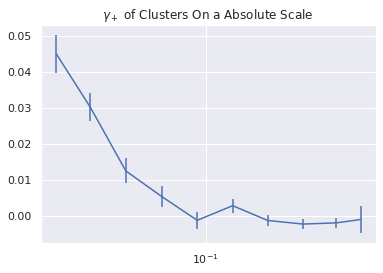

Aggregated xi:
[-21.3956 -29.8125 -19.2978 -13.6719   4.5321 -18.9029  11.1788  26.2087
  19.5656   1.3842]
------------------------------------------------------------------------------
Aggregated meanlogr:
[ -2058.5883  -3824.4644  -5206.2439  -7258.5536  -9723.25   -12590.7266
 -13814.1951 -11963.2584  -5725.0832   -319.6906]
------------------------------------------------------------------------------
Aggregated npairs:
[  476.   990.  1538.  2503.  4018.  6489.  9426. 12082. 10661.  1521.]
------------------------------------------------------------------------------
Mean xi:
[-0.0449 -0.0301 -0.0125 -0.0055  0.0011 -0.0029  0.0012  0.0022  0.0018
  0.0009]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.3248 -3.8631 -3.3851 -2.8999 -2.4199 -1.9403 -1.4655 -0.9902 -0.537
 -0.2102]
------------------------------------------------------------------------------


In [25]:
plt_w_error(mean_abs[1],-mean_abs[0],sig_abs,r"$\gamma_+$ of Clusters On a Absolute Scale ")
print_data(sum_abs,mean_abs)

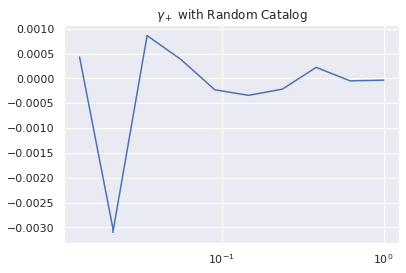

[ 4.3030e-04 -3.0562e-03  8.6036e-04  3.8116e-04 -2.2971e-04 -3.4155e-04
 -2.1683e-04  2.2134e-04 -5.0238e-05 -3.6069e-05]
[-6.8319e-06  4.8524e-05 -1.3660e-05 -6.0516e-06  3.6471e-06  5.4227e-06
  3.4425e-06 -3.5142e-06  7.9762e-07  5.7267e-07]


In [26]:
plt_w_error(r_meanlogr,-r_xi,r_sigma,r"$\gamma_+$ with Random Catalog")
print(-r_xi)
print(r_sigma)

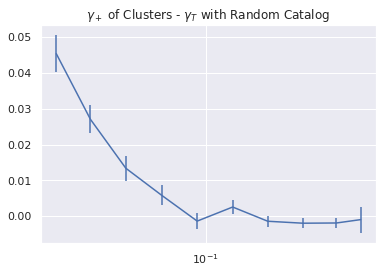

In [27]:
plt_w_error(mean_abs[1],-(mean_abs[0]+r_xi),np.hypot(r_sigma,sig_abs),r"$\gamma_+$ of Clusters - $\gamma_T$ with Random Catalog")

# Rel plots

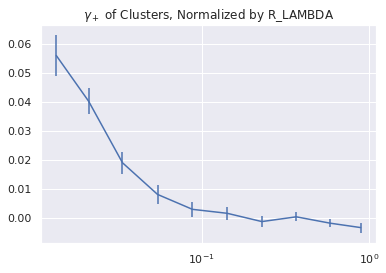

Aggregated xi:
[-13.5074 -27.764  -22.9063 -15.2395  -9.1201  -8.0919   9.2528  -4.5487
  21.7753  24.0468]
------------------------------------------------------------------------------
Aggregated meanlogr:
[ -1036.1584  -2656.4097  -4071.948   -5434.4803  -7357.3016  -9597.0321
 -11310.3212 -10586.824   -6602.1613   -878.298 ]
------------------------------------------------------------------------------
Aggregated npairs:
[  241.   689.  1201.  1868.  3028.  4915.  7662. 10550. 12301.  7334.]
------------------------------------------------------------------------------
Mean xi:
[-0.056  -0.0403 -0.0191 -0.0082 -0.003  -0.0016  0.0012 -0.0004  0.0018
  0.0033]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.2994 -3.8555 -3.3905 -2.9093 -2.4298 -1.9526 -1.4762 -1.0035 -0.5367
 -0.1198]
------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

In [28]:
plt_w_error(mean_rel[1],-mean_rel[0],sig_rel,r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA")
print_data(sum_rel,mean_rel)